In [2]:
import pandas as pd
train = pd.read_csv("data/Twitter/hate_twitter/train_E6oV3lV.csv")
test = pd.read_csv('data/Twitter/hate_twitter/test_tweets_anuFYb8.csv')

In [6]:
train.shape

(31962, 3)

In [47]:
test_str = "@user @user thanks for #lyft credit i can't "
re.findall(r"#(\w+)", test_str)

['lyft']

In [3]:
import re
import nltk
# nltk.download('stopwords')
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from string import punctuation

FLAGS = re.MULTILINE | re.DOTALL


def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = u"<hashtag> {} <allcaps>".format(hashtag_body)
    else:
        result = " ".join(["<hashtag>"] + re.split(u"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()


def remove_stopwords(text_lst):
    '''
    input: list of string
    '''
    if type(text_lst) == str:
        text_lst = text_lst.split()
    
    # Remove punctuations and stop words and other redundant terms tike 'rt', 'amp'
    stop_nltk = stopwords.words("english")
    stop_punct = list(punctuation)
    stop_punct.extend(['...','``',"''",".."])
    stop_context = ['rt', 'amp']
    stop_final = stop_nltk + stop_punct + stop_context
    result_lst = [re.sub("#","",term) for term in text_lst if ((term not in stop_final) & (len(term)>1))]
    result_string = " ".join(result_lst)
    return result_string

    
def  clean_text(df, text_field):
    df["hash_tag"] = df[text_field].apply(lambda elem: re.findall(r"#(\w+)", elem.lower()))  
    
    # clean tweet
    df["clean_tweet"] = df[text_field].str.lower()
    df["clean_tweet"] = df["clean_tweet"].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    
    # remove stopwords
    df["clean_tweet"] =  df["clean_tweet"].apply(remove_stopwords) 
    
    # tokenize based on customized function
    df["tokenized_tweet"] = df[text_field].apply(tokenize)
    
    # tokenize based on TweetTokenizer from NLTK
    tkn = TweetTokenizer()
    df["tokenized_tweet_NLTK"] = df[text_field].apply(tkn.tokenize)
    df["tokenized_tweet_NLTK"] = df["tokenized_tweet_NLTK"].apply(remove_stopwords)
    
    return df

In [101]:
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")


# Upsampling the Minority Class

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)



train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()


0    29720
1    29720
Name: label, dtype: int64

In [102]:
train_clean.head()

,id,label,tweet,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,1,0,@user when a father is dysfunctional and is s...,[run],father dysfunctional selfish drags kids dysfun...,<user> when a father is dysfunctional and is ...,@user father dysfunctional selfish drags kids ...
1,2,0,@user @user thanks for #lyft credit i can't us...,"[lyft, disapointed, getthanked]",thanks lyft credit cant use cause dont offer w...,<user> <user> thanks for <hashtag> lyft credit...,@user @user thanks lyft credit can't use cause...
2,3,0,bihday your majesty,[],bihday majesty,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,[model],model love take time ur,<hashtag> model <elong>i love u take with u a...,model love take time urð
4,5,0,factsguide: society now #motivation,[motivation],factsguide society motivation,factsguide: society now <hashtag> motivation,factsguide society motivation


In [103]:
train_clean[train_clean["hash_tag"].apply(lambda x: len(x) > 0)]

,id,label,tweet,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,1,0,@user when a father is dysfunctional and is s...,[run],father dysfunctional selfish drags kids dysfun...,<user> when a father is dysfunctional and is ...,@user father dysfunctional selfish drags kids ...
1,2,0,@user @user thanks for #lyft credit i can't us...,"[lyft, disapointed, getthanked]",thanks lyft credit cant use cause dont offer w...,<user> <user> thanks for <hashtag> lyft credit...,@user @user thanks lyft credit can't use cause...
3,4,0,#model i love u take with u all the time in ...,[model],model love take time ur,<hashtag> model <elong>i love u take with u a...,model love take time urð
4,5,0,factsguide: society now #motivation,[motivation],factsguide society motivation,factsguide: society now <hashtag> motivation,factsguide society motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[allshowandnogo],22 huge fan fare big talking leave chaos pay d...,[<number> / <number>] huge fan fare and big ta...,2/2 huge fan fare big talking leave chaos pay ...
...,...,...,...,...,...,...,...
31953,31954,0,good morning #instagram #shower #water #berlin...,"[instagram, shower, water, berlin, berlincityg...",good morning instagram shower water berlin ber...,good morning <hashtag> instagram <hashtag> sho...,good morning instagram shower water berlin ber...
31954,31955,0,#holiday bull up: you will dominate your bul...,[holiday],holiday bull dominate bull direct whatever want,<hashtag> holiday <elong>bull up: you will do...,holiday bull dominate bull direct whatever want
31955,31956,0,less than 2 weeks ð ðð¼ð¹ððµ @us...,"[ibiza, bringiton, mallorca, holidays, summer]",less weeks ibizabringitonmallorcaholidayssummer,less than <number> weeks ð ðð¼ð¹ðð...,less weeks @user ibiza bringiton mallorca holi...
31958,31959,0,to see nina turner on the airwaves trying to...,"[shame, imwithher]",see nina turner airwaves trying wrap mantle ge...,to see nina turner on the airwaves trying to...,see nina turner airwaves trying wrap mantle ge...


In [104]:
train_upsampled['clean_tweet'][5]

'22 huge fan fare big talking leave chaos pay disputes get allshowandnogo'

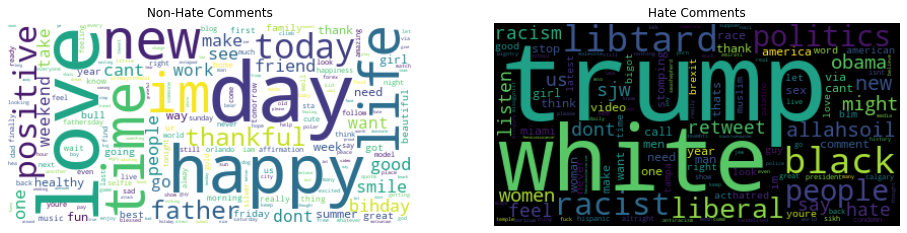

In [105]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['clean_tweet'][train.label == 0])
text_neg = " ".join(train_clean['clean_tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [106]:
train_upsampled.to_csv("data/Twitter/hate_twitter/train_upsampled.csv")

In [107]:
train_clean.to_csv("data/Twitter/hate_twitter/train_clean.csv")
test_clean.to_csv("data/Twitter/hate_twitter/test_clean.csv")


# Feature Extraction

In [ ]:
# https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction


import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.feature_extraction.text import CountVectorizer # BoW
from sklearn.metrics import f1_score, accuracy_score




## Clean tweets for prediction

In [4]:
tweets_to_classify = pd.read_csv("data/Twitter/twitter_info_annotated_racism_sexism.csv")
tweets_to_classify = tweets_to_classify[tweets_to_classify['Datetime'].notna()]
tweets_to_classify.head()

,Unnamed: 0,tweet_id,tag,Datetime,Tweet Id,Text,Username,Place,Coordinates,UserLocation
0,0,572342978255048705,racism,2015-03-02 10:29:34+00:00,5.723429782550487e+17,So Drasko just said he was impressed the girls...,thefoxbandit,NaN,NaN,NaN
1,1,572342978255048705,racism,2015-03-02 10:29:34+00:00,5.723429782550487e+17,So Drasko just said he was impressed the girls...,thefoxbandit,NaN,NaN,NaN
2,2,572341498827522049,racism,2015-03-02 10:23:41+00:00,5.7234149882752205e+17,Drasko they didn't cook half a bird you idiot ...,trish2295,"Place(fullName='Gold Coast, Queensland', name=...","Coordinates(longitude=153.37975174, latitude=-...",NaN
3,3,572341498827522049,racism,2015-03-02 10:23:41+00:00,5.7234149882752205e+17,Drasko they didn't cook half a bird you idiot ...,trish2295,"Place(fullName='Gold Coast, Queensland', name=...","Coordinates(longitude=153.37975174, latitude=-...",NaN
4,4,572340476503724032,racism,2015-03-02 10:19:37+00:00,5.72340476503724e+17,Hopefully someone cooks Drasko in the next ep ...,foodbling,NaN,NaN,"A bar, somewhere beachy"


In [5]:
to_classify_clean = clean_text(tweets_to_classify, "Text")
to_classify_clean.head()

,Unnamed: 0,tweet_id,tag,Datetime,Tweet Id,Text,Username,Place,Coordinates,UserLocation,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,0,572342978255048705,racism,2015-03-02 10:29:34+00:00,5.723429782550487e+17,So Drasko just said he was impressed the girls...,thefoxbandit,NaN,NaN,NaN,[mkr],drasko said impressed girls cooked half chicke...,so drasko just said he was impressed the girls...,So Drasko said impressed girls cooked half chi...
1,1,572342978255048705,racism,2015-03-02 10:29:34+00:00,5.723429782550487e+17,So Drasko just said he was impressed the girls...,thefoxbandit,NaN,NaN,NaN,[mkr],drasko said impressed girls cooked half chicke...,so drasko just said he was impressed the girls...,So Drasko said impressed girls cooked half chi...
2,2,572341498827522049,racism,2015-03-02 10:23:41+00:00,5.7234149882752205e+17,Drasko they didn't cook half a bird you idiot ...,trish2295,"Place(fullName='Gold Coast, Queensland', name=...","Coordinates(longitude=153.37975174, latitude=-...",NaN,[mkr],drasko didnt cook half bird idiot mkr,drasko they didn't cook half a bird you idiot ...,Drasko cook half bird idiot mkr
3,3,572341498827522049,racism,2015-03-02 10:23:41+00:00,5.7234149882752205e+17,Drasko they didn't cook half a bird you idiot ...,trish2295,"Place(fullName='Gold Coast, Queensland', name=...","Coordinates(longitude=153.37975174, latitude=-...",NaN,[mkr],drasko didnt cook half bird idiot mkr,drasko they didn't cook half a bird you idiot ...,Drasko cook half bird idiot mkr
4,4,572340476503724032,racism,2015-03-02 10:19:37+00:00,5.72340476503724e+17,Hopefully someone cooks Drasko in the next ep ...,foodbling,NaN,NaN,"A bar, somewhere beachy",[mkr],hopefully someone cooks drasko next ep mkr,hopefully someone cooks drasko in the next ep ...,Hopefully someone cooks Drasko next ep MKR


In [ ]:
to_classify_clean.to_csv("data/Twitter/clean_twitter_info_annotated.csv")